# Project: 
## Can a user's relationship status be predicted using other variables in their dating profile using a machine learning model, and which model performs best?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN

%matplotlib inline

In [2]:
profiles = pd.read_csv('profiles.csv')

In [3]:
profiles.drop(columns = ['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9', 'ethnicity', 'location'], inplace=True)

In [4]:
profiles['sign'] = profiles['sign'].str.split().str.get(0)
profiles['religion'] = profiles['religion'].str.split().str.get(0)

In [5]:
profiles = profiles.dropna()

In [6]:
def classify_diet(diet_str):
    if 'anything' in diet_str:
        return 'anything'
    elif 'other' in diet_str:
        return 'other'
    elif 'halal' in diet_str:
        return 'halal'
    elif 'kosher' in diet_str:
        return 'kosher'
    elif 'vegetarian' in diet_str:
        return 'vegetarian'
    elif 'vegan' in diet_str:
        return 'vegan'
profiles['diet'] = profiles['diet'].apply(classify_diet)

In [7]:
profiles['offspring'] = profiles['offspring'].str.replace("doesn&rsquo;t", "doesn't", regex=False)

In [8]:
for col in profiles:
    print(f'{col}: {profiles[col].unique()}\n{'-'*50}\n')

age: [22 35 31 29 33 30 32 26 42 45 23 50 21 59 27 37 28 43 34 41 53 39 47 48
 55 19 63 61 60 57 49 52 44 18 25 58 24 36 38 20 40 51 62 56 69 46 64 68
 67 66 65 54]
--------------------------------------------------

body_type: ['a little extra' 'average' 'thin' 'athletic' 'fit' 'curvy' 'skinny'
 'full figured' 'overweight' 'used up' 'jacked' 'rather not say']
--------------------------------------------------

diet: ['anything' 'other' 'halal' 'vegetarian' 'vegan' 'kosher']
--------------------------------------------------

drinks: ['socially' 'often' 'rarely' 'not at all' 'very often' 'desperately']
--------------------------------------------------

drugs: ['never' 'sometimes' 'often']
--------------------------------------------------

education: ['working on college/university' 'working on space camp'
 'graduated from college/university' 'graduated from masters program'
 'graduated from space camp' 'graduated from two-year college'
 'college/university' 'dropped out of high schoo

In [9]:
important_continuous_variables = ['age', 'height', 'income']

Text(0.5, 9.444444444444438, 'Age (years)')

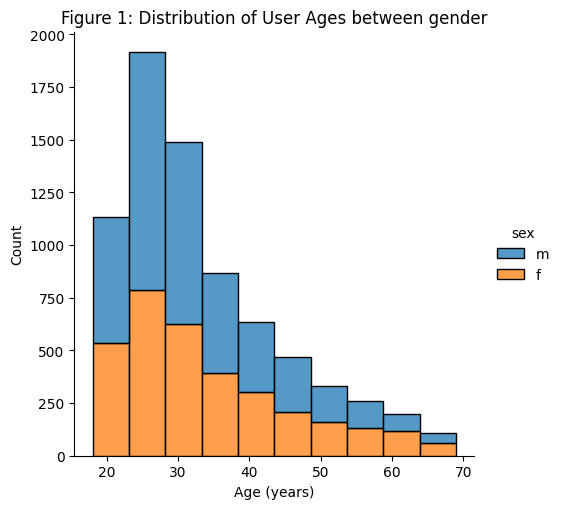

In [10]:
sns.displot(data=profiles, x="age", hue="sex", kind="hist", binwidth = 5, multiple = "stack")
plt.title('Figure 1: Distribution of User Ages between gender')
plt.xlabel('Age (years)')

Text(0.5, 9.444444444444438, 'Height (inches)')

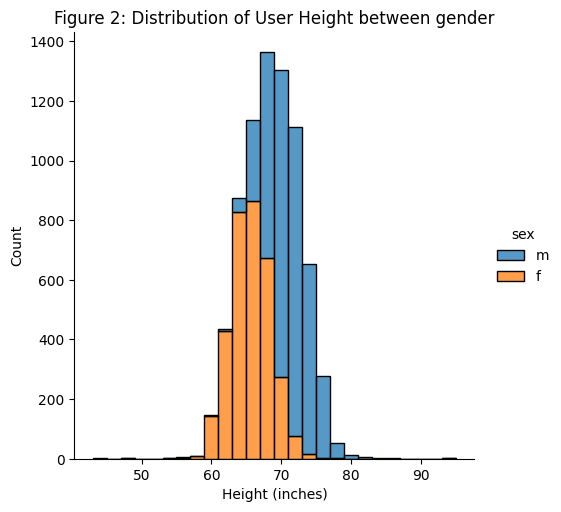

In [11]:
sns.displot(data=profiles, x="height", hue="sex", kind="hist", binwidth = 2, multiple = "stack")
plt.title('Figure 2: Distribution of User Height between gender')
plt.xlabel('Height (inches)')

Text(0.5, 9.444444444444438, 'Income ($ per year)')

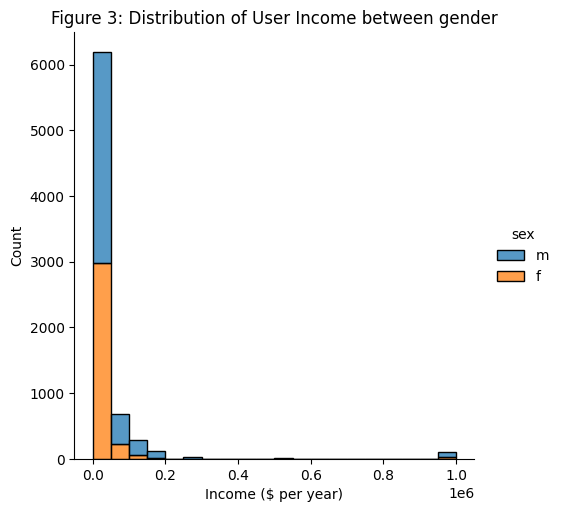

In [12]:
sns.displot(data=profiles, x="income",hue="sex", kind="hist", binwidth = 50000, multiple = "stack")
plt.title('Figure 3: Distribution of User Income between gender')
plt.xlabel('Income ($ per year)')

In [13]:
important_discrete_variables = ['body_type', 'diet', 'drinks', 'drugs', 'job', 'orientation', 'religion', 'sign', 'smokes', 'status']

Text(0.5, 1.0, 'Figure 4: Distribution of body type between gender')

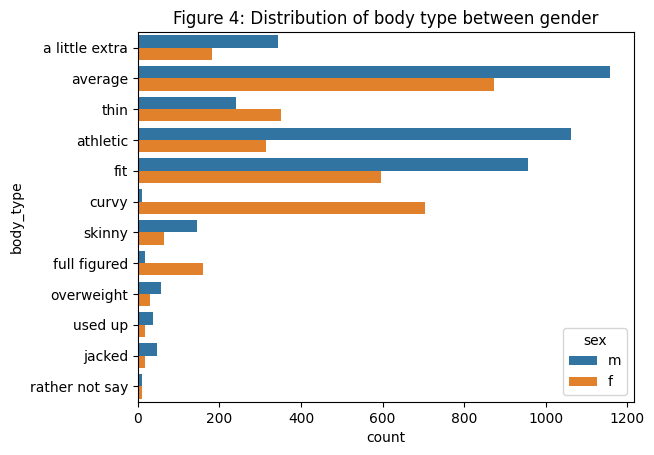

In [14]:
sns.countplot(data=profiles, y='body_type', hue='sex')
plt.title('Figure 4: Distribution of body type between gender')

Text(0.5, 1.0, 'Figure 5: Distribution of diet between gender')

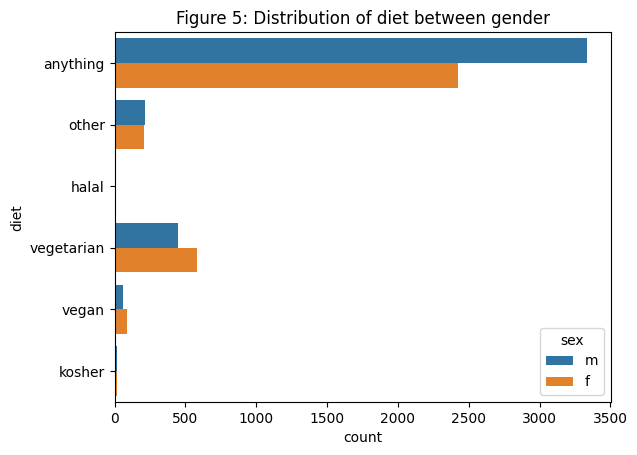

In [15]:
sns.countplot(data=profiles, y='diet', hue='sex')
plt.title('Figure 5: Distribution of diet between gender')

Text(0.5, 1.0, 'Figure 6: Distribution of drinking habits between gender')

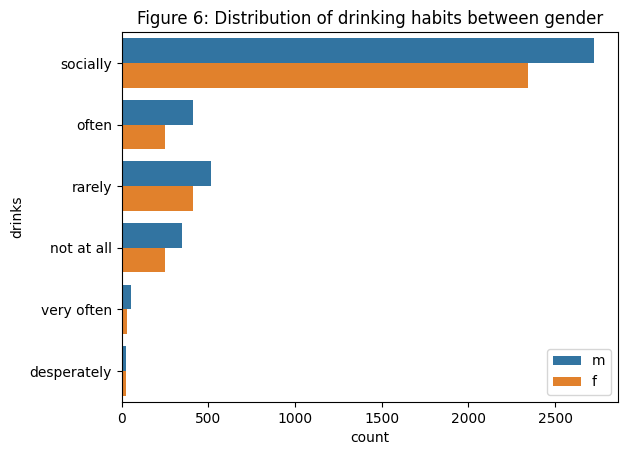

In [16]:
sns.countplot(data=profiles, y='drinks', hue='sex')
plt.legend(loc='lower right')
plt.title('Figure 6: Distribution of drinking habits between gender')

Text(0.5, 1.0, 'Figure 7: Distribution of drug use between gender')

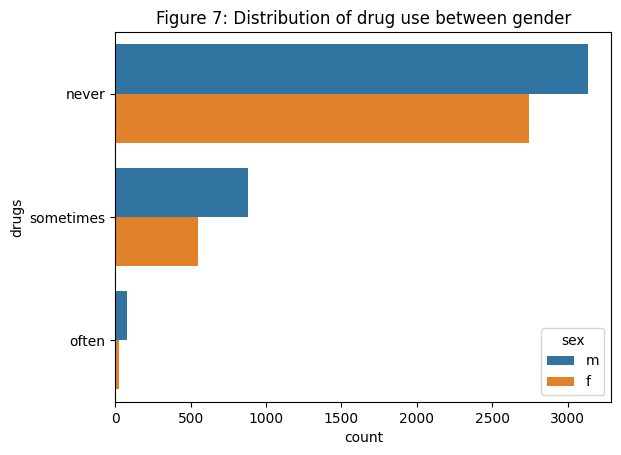

In [17]:
sns.countplot(data=profiles, y='drugs', hue='sex')
plt.title('Figure 7: Distribution of drug use between gender')

Text(0.5, 1.0, 'Figure 8: Distribution of jobs between gender')

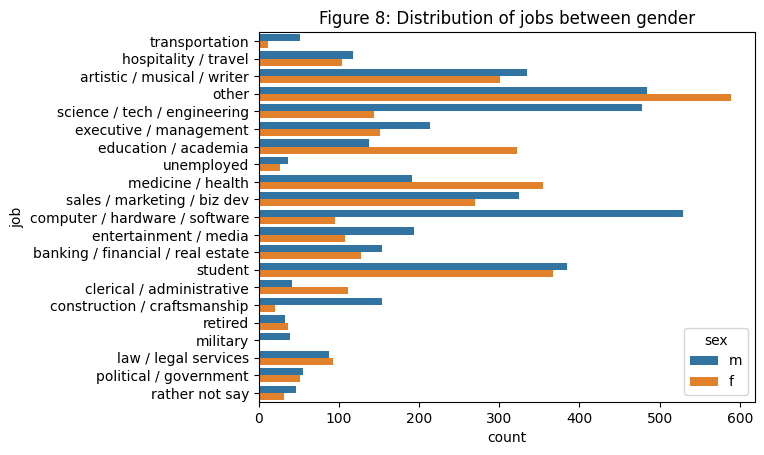

In [18]:
sns.countplot(data=profiles, y='job', hue='sex')
plt.title('Figure 8: Distribution of jobs between gender')

Text(0.5, 1.0, 'Figure 9: Distribution of sexual orientation between gender')

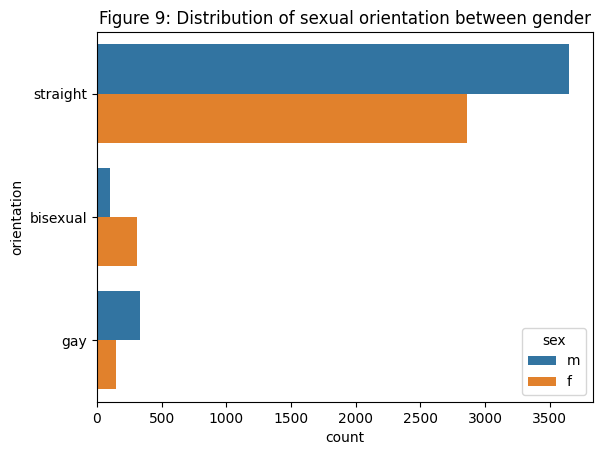

In [19]:
sns.countplot(data=profiles, y='orientation', hue='sex')
plt.title('Figure 9: Distribution of sexual orientation between gender')

Text(0.5, 1.0, 'Figure 10: Distribution of religion between gender')

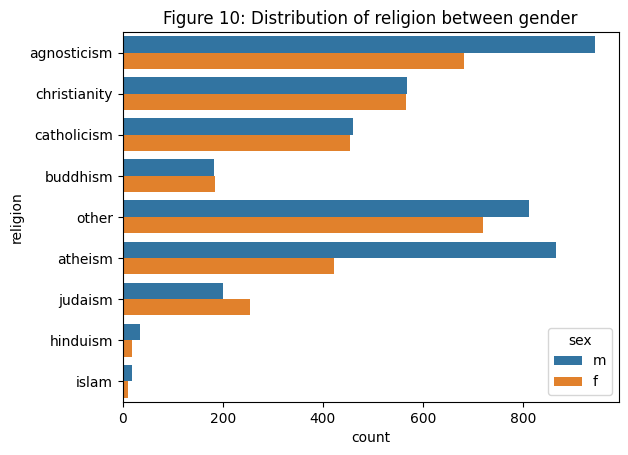

In [20]:
sns.countplot(data=profiles, y='religion', hue='sex')
plt.title('Figure 10: Distribution of religion between gender')

Text(0.5, 1.0, 'Figure 11: Distribution of star sign between gender')

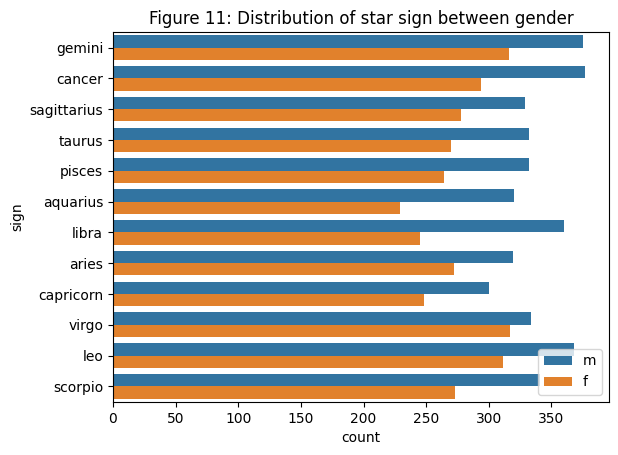

In [21]:
sns.countplot(data=profiles, y='sign', hue='sex')
plt.legend(loc='lower right')
plt.title('Figure 11: Distribution of star sign between gender')

Text(0.5, 1.0, 'Figure 12: Distribution of smoking habits between gender')

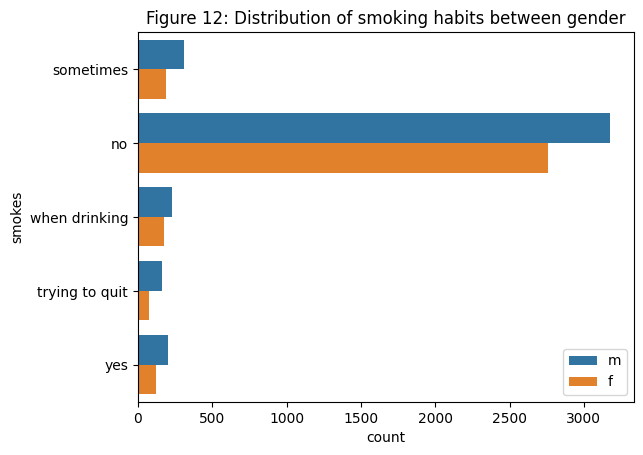

In [22]:
sns.countplot(data=profiles, y='smokes', hue='sex')
plt.legend(loc='lower right')
plt.title('Figure 12: Distribution of smoking habits between gender')

Text(0.5, 1.0, 'Figure 13: Distribution of relationship status between gender')

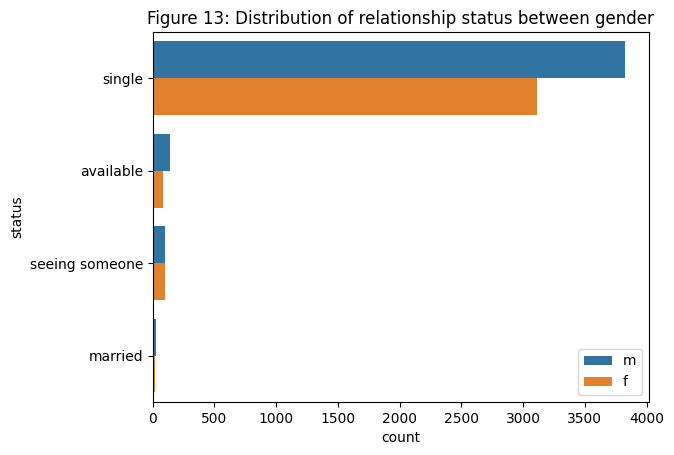

In [23]:
sns.countplot(data=profiles, y='status', hue='sex')
plt.legend(loc='lower right')
plt.title('Figure 13: Distribution of relationship status between gender')

In [24]:
# ------------------------------
# 1. Load and Select Data
# ------------------------------
important_variables = ['age', 'height', 'income', 'body_type', 'diet', 'drinks', 
                       'drugs', 'job', 'orientation', 'religion', 'sign', 'smokes', 'status']

df = profiles[important_variables].copy()

In [25]:
# ------------------------------
# 2. Separate Features and Target
# ------------------------------
y = df['status'].astype(str) # target variable
X = df.drop('status', axis=1)

In [26]:
# ------------------------------
# 3. Identify Categorical and Numeric Columns
# ------------------------------
categorical_cols = ['body_type', 'diet', 'drinks', 'drugs', 'job', 
                    'orientation', 'religion', 'sign', 'smokes']
numeric_cols = ['age', 'height', 'income']

In [27]:
# ------------------------------
# 4. One-Hot Encode Categorical Variables
# ------------------------------
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [28]:
# ------------------------------
# 5. Encode Target Labels
# ------------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [29]:
# ------------------------------
# 6. Define Stratified K-Fold Cross-Validation
# ------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [30]:
# ------------------------------
# 7. Define Pipelines for All Models
# ------------------------------
models = {
    "Random Forest": Pipeline([
        ('smoteenn', SMOTEENN(random_state=42)),
        ('clf', RandomForestClassifier(class_weight="balanced", random_state=42))
    ]),
    "Logistic Regression": Pipeline([
        ('smoteenn', SMOTEENN(random_state=42)),
        ('scaler', StandardScaler()),  # scale numeric features
        ('clf', LogisticRegression(max_iter=500, class_weight="balanced", random_state=42))
    ]),
    "K-Nearest Neighbors": Pipeline([
        ('smoteenn', SMOTEENN(random_state=42)),
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier(n_neighbors=5, weights="distance"))
    ]),
    "Decision Tree": Pipeline([
        ('smoteenn', SMOTEENN(random_state=42)),
        ('clf', DecisionTreeClassifier(class_weight="balanced", random_state=42))
    ]),
    "XGBoost": Pipeline([
        ('smoteenn', SMOTEENN(random_state=42)),
        ('clf', xgb.XGBClassifier(objective="multi:softmax",
                                  num_class=len(le.classes_),
                                  eval_metric="mlogloss",
                                  random_state=42))
    ])
}

In [31]:
# ------------------------------
# 8. Define Scorers for Macro Metrics
# ------------------------------
f1_macro_scorer = make_scorer(f1_score, average='macro')
precision_macro_scorer = make_scorer(precision_score, average='macro')
recall_macro_scorer = make_scorer(recall_score, average='macro')

In [32]:
# ------------------------------
# 9. Evaluate Each Model with Cross-Validation
# ------------------------------
results = []

for name, pipeline in models.items():
    print(f'Evaluating {name}...')
    # Compute cross-validated scores for F1, precision, recall
    f1_scores = cross_val_score(pipeline, X, y_encoded, cv=skf, scoring=f1_macro_scorer)
    precision_scores = cross_val_score(pipeline, X, y_encoded, cv=skf, scoring=precision_macro_scorer)
    recall_scores = cross_val_score(pipeline, X, y_encoded, cv=skf, scoring=recall_macro_scorer)

    # Store mean and standard deviation
    results.append({
        'Model': name,
        'F1 Macro Mean': f1_scores.mean(),
        'F1 Macro Std': f1_scores.std(),
        'Precision Macro Mean': precision_scores.mean(),
        'Precision Macro Std': precision_scores.std(),
        'Recall Macro Mean': recall_scores.mean(),
        'Recall Macro Std': recall_scores.std()
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1 Macro Mean', ascending=False)

print('\nTable 1: Model Performance Summary (Mean ± Std):')
results_df

Evaluating Random Forest...


C:\Users\sammy\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Evaluating Logistic Regression...
Evaluating K-Nearest Neighbors...
Evaluating Decision Tree...
Evaluating XGBoost...

Table 1: Model Performance Summary (Mean ± Std):


,Model,F1 Macro Mean,F1 Macro Std,Precision Macro Mean,Precision Macro Std,Recall Macro Mean,Recall Macro Std
4,XGBoost,0.277017,0.022139,0.274179,0.020856,0.290944,0.027491
1,Logistic Regression,0.273536,0.016036,0.276516,0.021627,0.275008,0.016635
2,K-Nearest Neighbors,0.273441,0.012576,0.271799,0.013077,0.279090,0.013594
0,Random Forest,0.267337,0.005170,0.265143,0.005575,0.271190,0.006330
3,Decision Tree,0.250588,0.004235,0.263200,0.003294,0.295085,0.014086


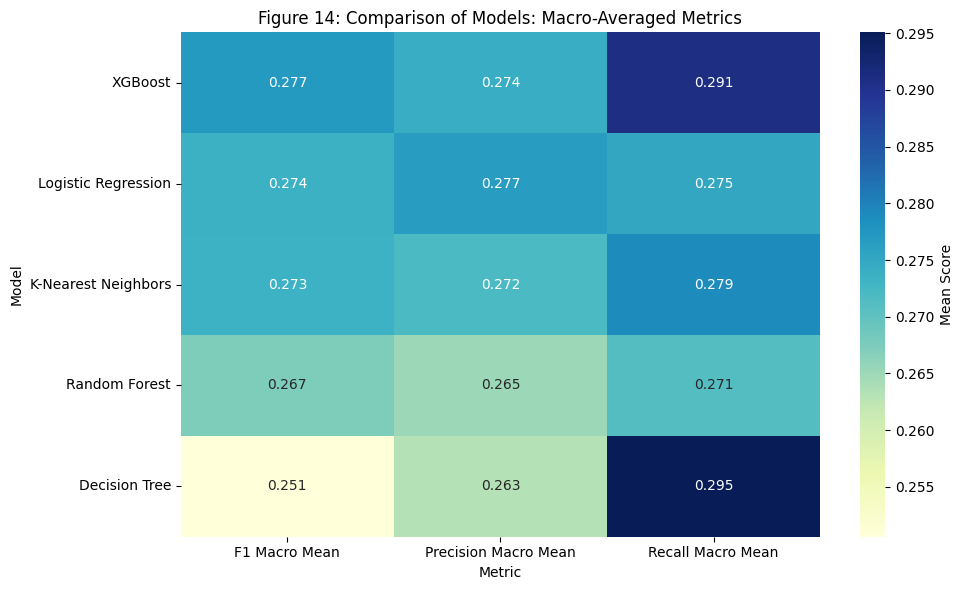

In [33]:
# ------------------------------
# 10. Heatmap of Mean Metrics
# ------------------------------
heatmap_data = results_df.set_index('Model')[['F1 Macro Mean', 'Precision Macro Mean', 'Recall Macro Mean']]

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlGnBu', cbar_kws={'label': 'Mean Score'})
plt.title('Figure 14: Comparison of Models: Macro-Averaged Metrics')
plt.ylabel('Model')
plt.xlabel('Metric')
plt.tight_layout()
plt.show()

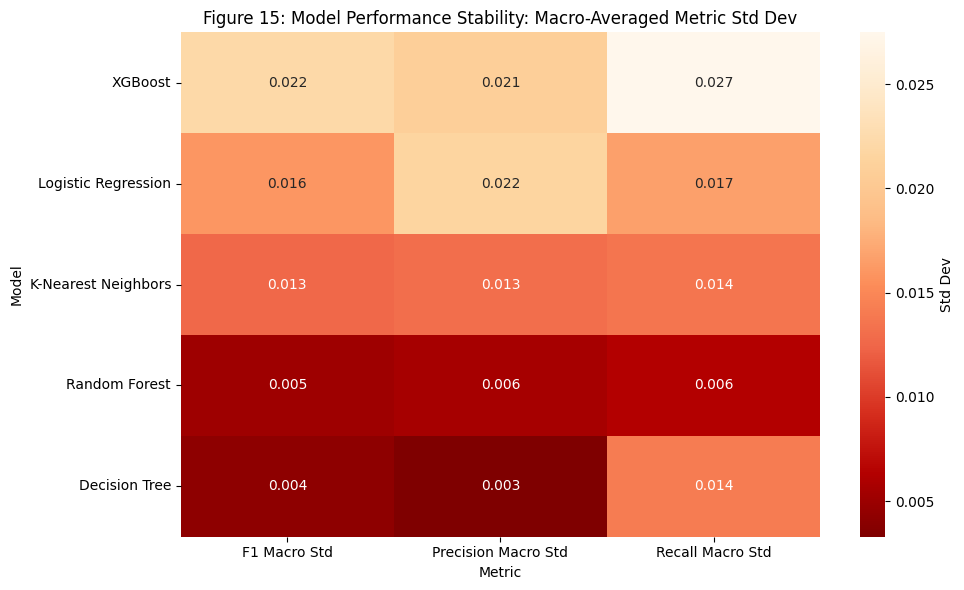

In [34]:
# ------------------------------
# 11. Heatmap of Standard Deviations (Stability)
# ------------------------------
std_heatmap_data = results_df.set_index('Model')[['F1 Macro Std', 'Precision Macro Std', 'Recall Macro Std']]

plt.figure(figsize=(10, 6))
sns.heatmap(std_heatmap_data, annot=True, fmt='.3f', cmap='OrRd_r', cbar_kws={'label': 'Std Dev'})
plt.title('Figure 15: Model Performance Stability: Macro-Averaged Metric Std Dev')
plt.ylabel('Model')
plt.xlabel('Metric')
plt.tight_layout()
plt.show()

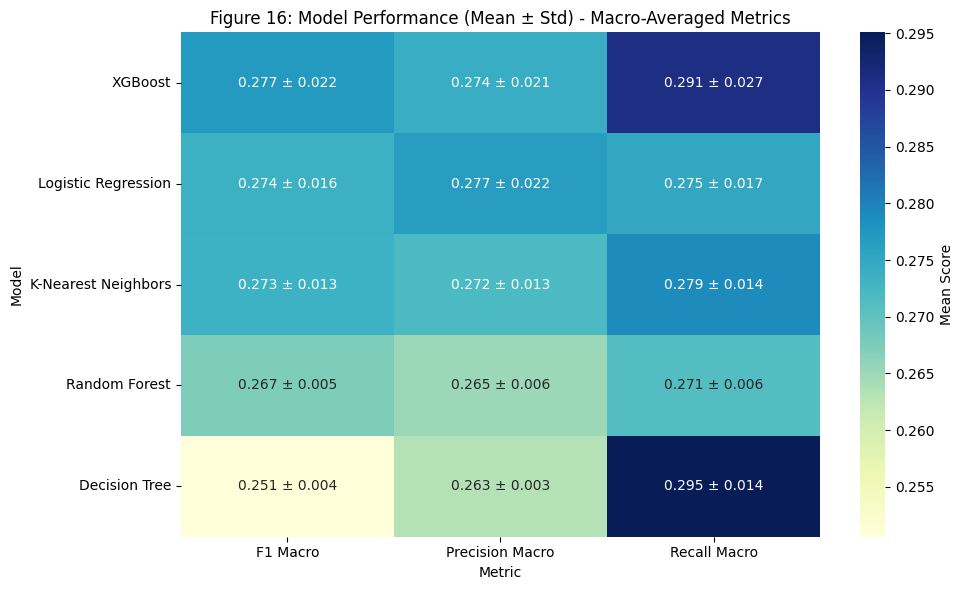

In [35]:
# ------------------------------
# 12. Combined Heatmap: Mean ± Std
# ------------------------------
combined_data = results_df.set_index('Model')
metrics = ['F1 Macro', 'Precision Macro', 'Recall Macro']
heatmap_values = pd.DataFrame(index=combined_data.index, columns=metrics)
heatmap_annotations = pd.DataFrame(index=combined_data.index, columns=metrics)

for metric in metrics:
    mean_col = f'{metric} Mean'
    std_col = f'{metric} Std'
    heatmap_values[metric] = combined_data[mean_col] # colour by mean
    heatmap_annotations[metric] = combined_data.apply(lambda row: f'{row[mean_col]:.3f} ± {row[std_col]:.3f}', axis=1)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_values.astype(float), annot=heatmap_annotations, fmt='', cmap='YlGnBu',
            cbar_kws={'label': 'Mean Score'})
plt.title('Figure 16: Model Performance (Mean ± Std) - Macro-Averaged Metrics')
plt.ylabel('Model')
plt.xlabel('Metric')
plt.tight_layout()
plt.show()

In [36]:
# ------------------------------
# 13. Stability-Adjusted Ranking
# ------------------------------
ranking_df = results_df.copy()
ranking_df['F1 Macro Score'] = ranking_df['F1 Macro Mean'] - ranking_df['F1 Macro Std']
ranking_df['Precision Macro Score'] = ranking_df['Precision Macro Mean'] - ranking_df['Precision Macro Std']
ranking_df['Recall Macro Score'] = ranking_df['Recall Macro Mean'] - ranking_df['Recall Macro Std']
ranking_df['Overall Score'] = ranking_df[['F1 Macro Score', 'Precision Macro Score', 'Recall Macro Score']].mean(axis=1)
ranking_df = ranking_df.sort_values(by='Overall Score', ascending=False)

print('\nTable 2: Stability-Adjusted Model Ranking:')
ranking_df[['Model', 'F1 Macro Score', 'Precision Macro Score', 'Recall Macro Score', 'Overall Score']]


Table 2: Stability-Adjusted Model Ranking:


,Model,F1 Macro Score,Precision Macro Score,Recall Macro Score,Overall Score
3,Decision Tree,0.246353,0.259906,0.280999,0.262419
0,Random Forest,0.262167,0.259568,0.264859,0.262198
2,K-Nearest Neighbors,0.260865,0.258722,0.265496,0.261694
4,XGBoost,0.254878,0.253323,0.263453,0.257218
1,Logistic Regression,0.257500,0.254889,0.258374,0.256921


C:\Users\sammy\AppData\Local\Temp\ipykernel_13544\600142918.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Overall Score', y='Model', data=ranking_df, palette='viridis')


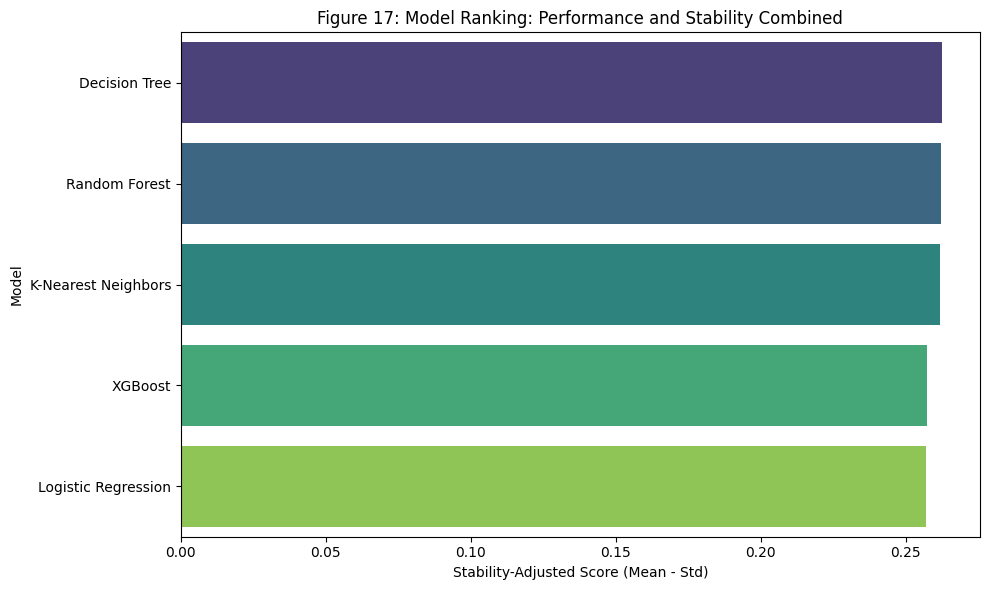

In [37]:
# ------------------------------
# 14. Bar Chart of Stability-Adjusted Scores
# ------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(x='Overall Score', y='Model', data=ranking_df, palette='viridis')
plt.title('Figure 17: Model Ranking: Performance and Stability Combined')
plt.xlabel('Stability-Adjusted Score (Mean - Std)')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

# Conclusion

Macro-averaged (weighted) scoring metrics were used in this project as the 'status' class is heavily imbalanced, as most users record 'single' as their status (as one would expect to see on a dating app), as seen in Figure 13.

#### Overall Performance Summary
Looking at Table 1, as well as Figures 14, 15, and 16, the following conclusions can be drawn:
- All 5 machine learning models achieve fairly low macro-F1 scores, ranging from around 0.25 - 0.28.
  - For comparison, simply guessing across 4-5 classes would give a macro-F1 score of around 0.20 - 0.25.
  - Therefore, in this instance, the machine learning models are only just better than random chance.
- The model with the greatest absolute performance appears to be XGBoost, with an F1 and Recall score of 0.277 and 0.291, respectively. However, with a higher standard deviation than the other models, this means that XGBoost is less stable.
- Despite being the 2nd weakest in performace, Random Forest has the lowest standard deviation across the models, making it the most stable.
- Decision Tree has the lowest F1 score of 0.251, but a relatively high recall, meaning that it successfully 'finds' more minority-class examples, but suffers in precision as a result.

#### Stability-Adjusted Model Ranking

As well as analysing the models' original scoring metrics, the standard deviation of each score for each model was subtracted from the respective mean values. This is to penalise models with high standard deviation, so models with high performance and low variability rank higher. An 'Overall Score' was computed here also, taking the mean of F1, precision, and recall.

Tables 2, and Figure 17 reveals that:
- After stability is ensured in the scoring metrics, there is barely a siginifcant difference between model performance in terms of their Overall Score (this can especially be seen visually in Figure 17) - all models perform somewhat identically (0.256 - 0.262).
- Despite a low F1 score, a stable recall value leads to Decision Tree ranking first this time, even though its absolute performance was objectively the weakest before now.
- XGBoost and Logistic Regression, whilst higher in scoring metrics as shown by Figure 14 and 16, rank lower once stability is considered, due to their higher standard deviations.

## Overall Conclusion

Across the board, performance by the machine learning models was low, leading one to believe that this was most likely because of the heavy imbalance in the target variable 'status'. Most users have their status 'single', so the models mainly learn to predict this value. Macro-averaging the scoring metrics tried to correct for this, by giving the minority classes like 'married' or 'divorced' equal weight, which the models appeared to struggle with as a result of the imbalance, leading to the low scores.
#### Key Takeaways:
- The machine learning models used in this scenario were only slightly better than random chance, but not by much.
- For most models, they possess higher recall than precision. This means that whilst they do catch more minority-class cases, they do so with a lot of false positives and negatives.
- As for which model is the 'best', whilst Decision Tree ranks highest once accounted for stability, it still has a weak absolute performance, so it's more like the 'least bad' machine learning model rather than the superior one above the rest.

This implies that improvement in model performance will come with better data representation and handling class imbalance, rather than just trying a different machine learning algorithm.

# Next Steps - Potential Improvements
As stated, the main reason whilst a satisfying conclusion was not able to be drawn from this project was due to the imbalance in the target variable. As such, better handling of this imbalance could be worth trying out to improve performance of the models. This can be done via, for example, trying other resampling methods, or using ensemble methods in the code such as EasyEnsemble or BalancedRandomForest.

Another potential improvement to this project could be to reframe the task at the beginning. For example, if 'single' dominates the 'status' variable (which it does), predicting 'single vs not single' and then a second classifier for the smaller categories could work.